In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import yaml
import json
import sys

sys.path.append('..')
sys.path.append('../diploma_thesis/')

from environment import Statistics

plt.style.use('seaborn-v0_8-paper')

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Util

In [2]:
def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

In [3]:
def plot_value(path: str, info: dict, figsize=(8,8), post_process_fn = lambda a: a):
    if not os.path.exists(path):
        raise ValueError('No loss file exists')

    df = pd.read_csv(path)

    fig, ax = plt.subplots(figsize=figsize)

    if 'work_center_id' in df.columns:
        work_centers = df['work_center_id'].unique()
        machines = df['machine_id'].unique()

        for work_center_id in work_centers:
            for machine_id in machines:
                filtered = df[(df['work_center_id'] == work_center_id) & (df['machine_id'] == machine_id)]
                filtered.set_index(info['index'], inplace=True)

                if len(machines) == 1:
                    label = f'M_idx: {work_center_id}'
                else:
                    label = f'W_idx: {work_center_id}, M_idx: {machine_id}'

                ax.plot(post_process_fn(filtered[info['column']]), label=label)
    else:
        df.set_index(info['index'], inplace=True)

        ax.plot(post_process_fn(df[info['column']]))

    ax.grid(True)
    ax.set_title(info['title'])
    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])

    ax.legend()

    return fig, df

In [4]:
def plot_reward_distribution_per_action(data: pd.DataFrame, figsize=(8, 8)):
    data = data[data['reward'] != 0]

    fig, ax = plt.subplots(figsize=figsize)

    # Create violins for each action
    for i, action in enumerate(data["action"].unique()):
        action_data = data[data["action"] == action]["reward"]
        violin_parts = ax.violinplot(
            action_data,
            positions=[i],
            showmeans=True,
            showextrema=True,
            quantiles=[0.25, 0.5, 0.75],
        )

        violin_parts['bodies'][0].set_linewidth(2)

    # Set labels and title
    ax.set_xlabel("Action")
    ax.set_ylabel("Reward")
    ax.set_title("Violin Plot of Rewards by Action")

    # Add grid and adjust layout
    ax.grid(True)
    plt.tight_layout()

    return fig


In [5]:
def plot_reward_per_run(data, info, format_group):
    metric = info['metric']
    reward = info['reward']
    group = info['group']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', label=format_group(run))

    ax.grid(True)
    ax.legend()

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'])

    plt.tight_layout()

    return fig

def plot_reward_per_model_across_runs(data, info):
    metric = info['metric']
    reward = info['reward']
    group = info['group']
    candidate_column = info['candidate_column']
    candidates = info['candidates']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', c='gray')

    for candidate in candidates:
        filtered = data[data[candidate_column] == candidate]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ms=10, ls='', label=candidate)

    ax.grid(True)

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'])

    if len(candidates) > 1:
        ax.legend()

    plt.tight_layout()

    return fig

In [6]:
def filter_models(dataset, predicate):
    result = []

    for directory in os.listdir(dataset):
        directory_path = os.path.join(dataset, directory)

        if not os.path.isdir(directory_path):
            continue

        parameters = get_parameters(directory_path)

        if predicate(parameters):
            result += [directory]

    return result

# JSP

In [7]:
dataset = '../diploma_thesis/tmp/jsp_deep_marl/'

## Training

In [330]:
candidate_path = os.path.join(dataset, 'model_4')

In [331]:
agent_path = os.path.join(candidate_path, 'agent')

### Parameters

In [332]:
parameters = get_parameters(candidate_path)

print(json.dumps(parameters, indent=4))

{
    "log_stdout": false,
    "machine_agent": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/machine_agent/model.yml",
            "mods": [
                "rl/trainer/dqn.yml",
                "rl/agent/multi_agent.yml",
                "memory/plain.yml",
                "memory/small.yml",
                "loss/huber.yml",
                "optimizer/sgd.yml",
                "encoding/indirect.yml",
                "model/rules/marl.yml",
                "model/model/marl_as.yml",
                "scheduler/exponential.yml"
            ]
        }
    },
    "name": "model_4",
    "output_dir": "tmp/jsp_deep_marl",
    "run": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/run/jsp/run.yml",
            "mods": [
                "util_80.yml"
            ]
        }
    },
    "simulator": {
        "kind": "td"
    },
    "tape": {
        "machine_reward": {
            "kind": "global_d

### Loss

,Unnamed: 0,value,optimizer_step,lr,work_center_id,machine_id
0,0,0.010502,1,[0.00099996],0,0
1,1,0.009488,2,[0.0009999200016],0,0
2,2,0.010677,3,[0.000999880004799936],0,0
3,3,0.010941,4,[0.0009998400095997438],0,0
4,4,0.010665,5,[0.0009998000159993597],0,0
...,...,...,...,...,...,...
174502,17467,0.000169,17468,[0.0004972143914495854],9,0
174503,17468,0.000186,17469,[0.0004971945028739274],9,0
174504,17469,0.000554,17470,[0.0004971746150938123],9,0
174505,17470,0.000230,17471,[0.0004971547281092085],9,0


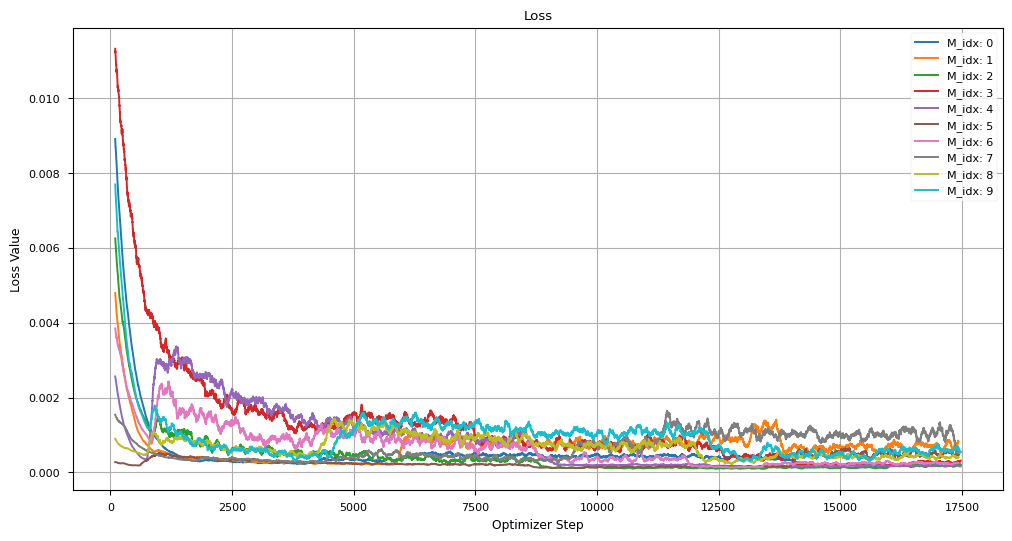

In [333]:
def smooth(x):
    return x.rolling(window=100).mean()

machine_loss = os.path.join(agent_path, 'machine_loss.csv')

fig, loss = plot_value(
    machine_loss,
    info=dict(
        column='value',
        title='Loss',
        xlabel='Optimizer Step',
        ylabel='Loss Value',
        index='optimizer_step'
    ),
    figsize=(12, 6),
    post_process_fn=smooth)

loss

### Reward

,reward,work_center_id,action,shop_floor_id,moment,machine_id
0,-0.006207,2,1,0,29.579218,0
1,-0.000447,9,1,0,38.579216,0
2,-0.008308,5,1,0,79.579216,0
3,-0.049307,3,3,0,164.579224,0
4,-0.038587,8,2,0,214.530533,0
...,...,...,...,...,...,...
25890,-0.023146,3,2,0,99727.343750,0
25891,-0.000086,5,2,0,99731.343750,0
25892,-0.004774,0,1,0,99752.343750,0
25893,-0.094725,8,2,0,99879.187500,0


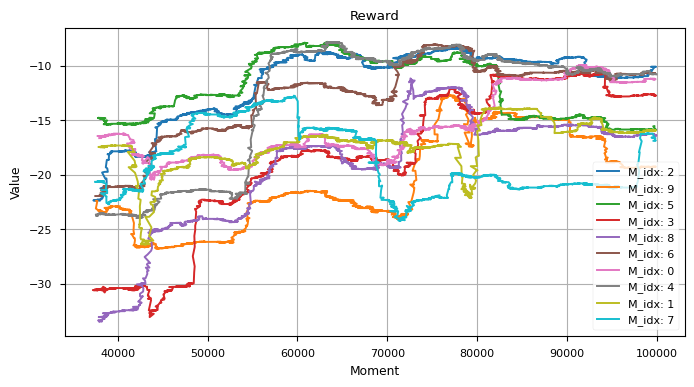

In [339]:
def sum(x):
    return x.rolling(window=1000).sum()

run = '_1'

machine_reward = os.path.join(candidate_path, 'run', run, 'machine_reward.csv')

fig, reward = plot_value(
    machine_reward,
    info=dict(
        column='reward',
        title='Reward',
        xlabel='Moment',
        ylabel='Value',
        index='moment'
    ),
    figsize=(8, 4),
    post_process_fn=sum)

reward

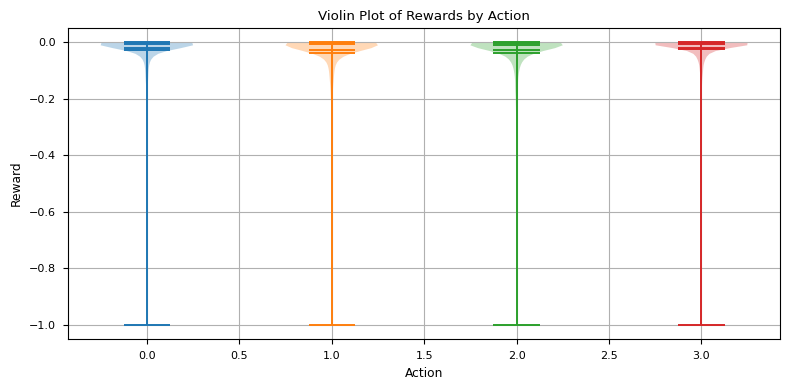

In [340]:
plot_reward_distribution_per_action(reward, figsize=(8,4));

#### Decisions per machine

In [341]:
by_action = reward.groupby(['machine_id', 'work_center_id', 'action']).count()['shop_floor_id'].reset_index()
by_action = by_action.rename({'shop_floor_id': 'count'}, axis=1)

by_action

,machine_id,work_center_id,action,count
0,0,0,0,647
1,0,0,1,660
2,0,0,2,680
3,0,0,3,584
4,0,1,0,641
5,0,1,1,676
6,0,1,2,651
7,0,1,3,614
8,0,2,0,617
9,0,2,1,683


## Tournament

#### Tournament Result

In [342]:
tournament_path = '../diploma_thesis/tmp/jsp_tournament/'

In [343]:
report_path = os.path.join(tournament_path, 'report.txt')

with open(report_path) as f:
    result = f.readlines()

print(''.join(result))

+----------------------------------------+----------------------+----------------------+---------------------+
|               candidate                |   makespan_reward    |   tardiness_reward   |      total_sum      |
+----------------------------------------+----------------------+----------------------+---------------------+
|          deep_marl_model_123           | 0.08346021827310324  |  0.0798014845083787  | 0.16326170278148194 |
|           deep_marl_model_78           | 0.07507745386101305  |  0.0828714342500375  | 0.15794888811105057 |
|          deep_marl_model_137           |  0.0842181199695915  | 0.07372224364807768  | 0.15794036361766917 |
|           deep_marl_model_89           | 0.07701240479946136  | 0.07919336941060928  | 0.15620577421007065 |
| DPTWINQNPTSchedulingRule_CTRoutingRule | 0.07861128263175488  | 0.07639116033568705  | 0.15500244296744192 |
|   CRSPTSchedulingRule_CTRoutingRule    | 0.07408403162844479  | 0.07905592304711305  | 0.15313995467555785 |
|

In [16]:
result_path = os.path.join(tournament_path, 'result.csv')
results = pd.read_csv(result_path)

#### Tournament Reward Distribution per Simulation

In [17]:
results

,Unnamed: 0,candidate,run,makespan,tardiness,makespan_reward,tardiness_reward
0,0,ATCSchedulingRule_CTRoutingRule,_1,7044.5303,92.797127,0.006418,0.004851
1,1,ATCSchedulingRule_CTRoutingRule,_2,6994.5100,74.551613,0.003650,0.006793
2,2,ATCSchedulingRule_CTRoutingRule,_3,6161.7590,218.291245,0.005457,0.005622
3,3,ATCSchedulingRule_CTRoutingRule,_4,7738.4180,71.911903,0.003504,0.005741
4,4,ATCSchedulingRule_CTRoutingRule,_5,7737.6387,100.596504,0.000000,0.006257
...,...,...,...,...,...,...,...
3325,3325,deep_marl_model_102,_11,6527.1406,350.706879,0.005868,0.000000
3326,3326,deep_marl_model_102,_12,6404.7970,339.020355,0.005021,0.001753
3327,3327,deep_marl_model_102,_13,7028.0234,194.441055,0.005294,0.001653
3328,3328,deep_marl_model_102,_14,6177.2344,270.295868,0.007192,0.002792


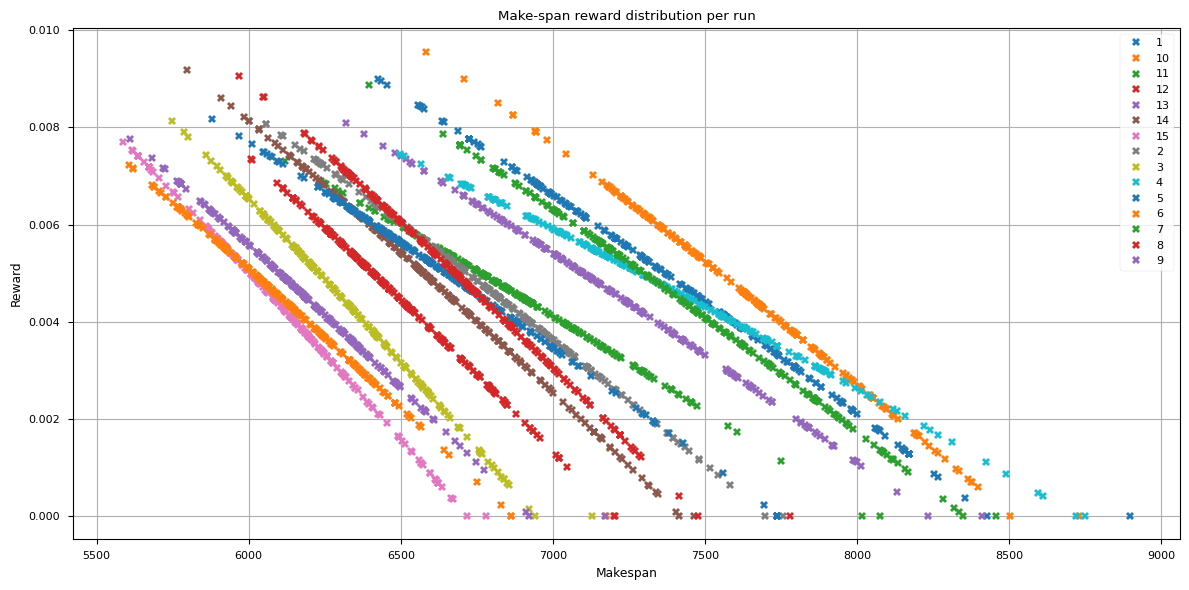

In [18]:
plot_reward_per_run(
    results,
    info=dict(
        title='Make-span reward distribution per run',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

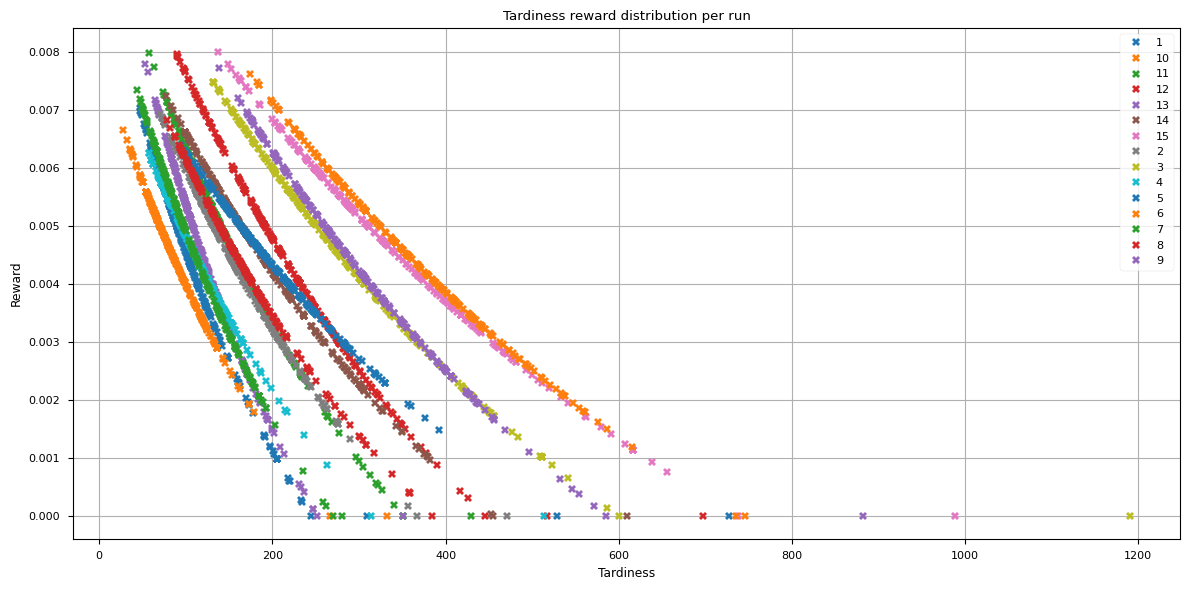

In [19]:
plot_reward_per_run(
    results,
    info=dict(
        title='Tardiness reward distribution per run',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

#### Reward Distribution per model

In [316]:
models = ['deep_marl_model_5', 'deep_marl_model_175', 'deep_marl_model_177']

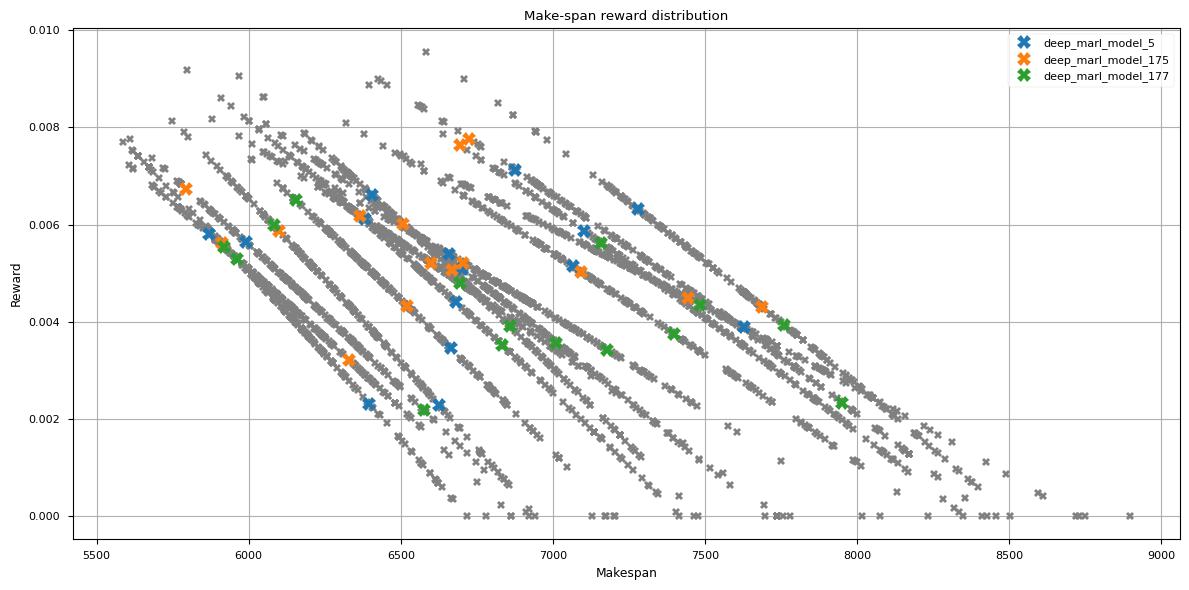

In [317]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Make-span reward distribution',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        candidate_column='candidate',
        candidates=models,
        group='run'
    )
);

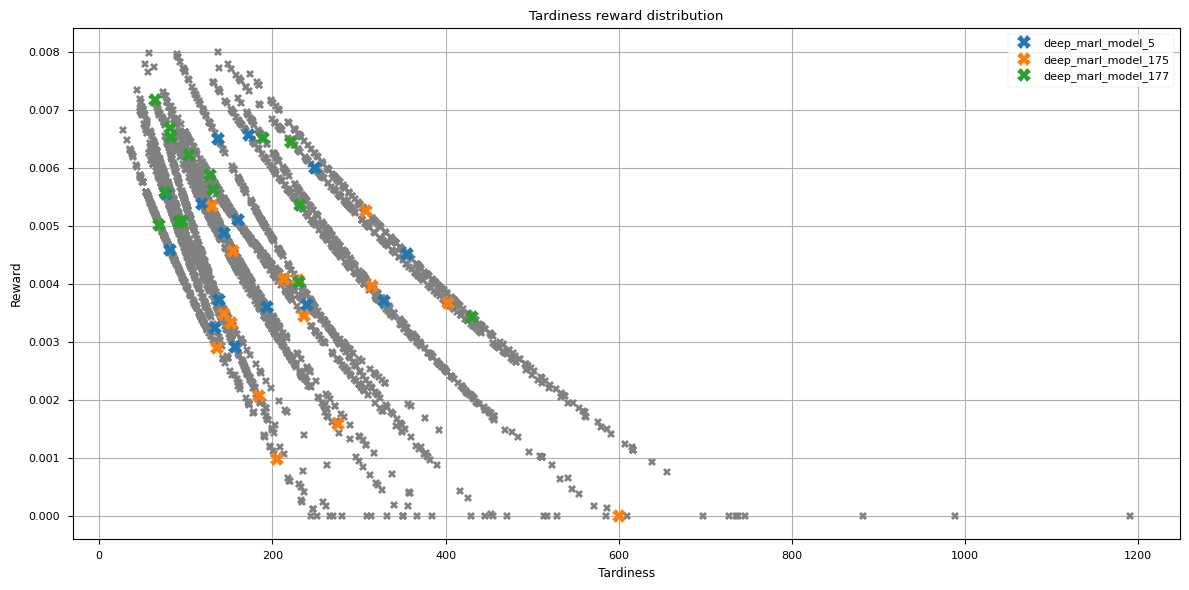

In [318]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Tardiness reward distribution',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        candidate_column='candidate',
        candidates=models,
        group='run'
    )
);

#### Analyze results

In [23]:
reward_columns = [column for column in results.columns if 'reward' in column ]

results_per_candidate = results.copy()

results_per_candidate = results_per_candidate[['candidate', *reward_columns]].groupby(['candidate']).sum()
results_per_candidate['reward'] = 0

for column in reward_columns:
    results_per_candidate['reward'] += results_per_candidate[column]

results_per_candidate = results_per_candidate.sort_values(by=['reward'], ascending=False).reset_index()

results_per_candidate

,candidate,makespan_reward,tardiness_reward,reward
0,deep_marl_model_123,0.083460,0.079801,0.163262
1,deep_marl_model_78,0.075077,0.082871,0.157949
2,deep_marl_model_137,0.084218,0.073722,0.157940
3,deep_marl_model_89,0.077012,0.079193,0.156206
4,DPTWINQNPTSchedulingRule_CTRoutingRule,0.078611,0.076391,0.155002
...,...,...,...,...
217,FIFOSchedulingRule_CTRoutingRule,0.068385,0.036169,0.104554
218,LIFOSchedulingRule_CTRoutingRule,0.057569,0.039906,0.097476
219,LROSchedulingRule_CTRoutingRule,0.047264,0.049595,0.096859
220,NPTSchedulingRule_CTRoutingRule,0.055071,0.036829,0.091900


In [24]:
def filter_by_mod(parameters, predicate):
    mods = parameters['machine_agent']['parameters']['mods']

    for mod in mods:
        if predicate(mod):
            return True

    return False

models = filter_models(dataset, lambda parameters: filter_by_mod(parameters, lambda mod: 'priori' in mod))

In [25]:
len(models)

96

In [26]:
candidates = results_per_candidate[results_per_candidate['candidate'].isin(models)]

candidates

,candidate,makespan_reward,tardiness_reward,reward


## Simulation Analysis

#### Utils

In [261]:
def plot_gantt(df: pd.DataFrame, info: dict, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    start_moment, end_moment = info['window']
    production_logs = df

    for block in info['blocks']:
        start_event, end_event = block['events']

        windows = production_logs[(production_logs['moment'] < end_moment) & (production_logs['moment'] >= start_moment)].copy()
        windows = windows[(windows['event'] == start_event) | (windows['event'] == end_event)]

        for event in [start_event, end_event]:
            windows.loc[windows['event'] == event, 'index'] = range(len(windows[windows['event'] == event]))

        windows = windows.set_index(['index', 'job_id', 'operation_id', 'work_center_idx', 'machine_idx'])

        result = windows[windows['event'] == start_event].copy()
        result['end_moment'] = windows[windows['event'] == end_event]['moment']

        result.drop(['event'], axis=1, inplace=True)
        result = result.reset_index()

        result['end_moment'] = result['end_moment'].fillna(end_moment)

        for job_id in result['job_id'].unique():
            job = result[result['job_id'] == job_id]

            rects = ax.barh(
                y=job['work_center_idx'],
                width=job['end_moment'] - job['moment'],
                left=job['moment'],
                label=f'Job {job_id}',
                **block['style']
            )

    ax.set_title(info['title'])
    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])

    return fig

#### Main

In [262]:
run_path = '../diploma_thesis/tmp/test/run/_1/'

In [263]:
statistics = Statistics.load(run_path)

In [264]:
statistics.shop_floor_history.jobs[1].history.started_at

tensor([  0, 126, 218, 264, 295, 330, 350, 451, 503])

In [265]:
print(statistics.report())

+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
|    | weighted_by_priority   |   total_jobs |   completed_jobs |   makespan |   flow_time |   tardiness |   tardy_jobs |   earliness |
|----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------|
|  0 | True                   |          265 |              257 |    9986.24 |     505.756 |     81.9114 |     0.540856 |     68.8455 |
|  1 | False                  |          265 |              257 |    9986.24 |  129979     |  21051.2    |   139        |  17693.3    |
+----+------------------------+--------------+------------------+------------+-------------+-------------+--------------+-------------+
+--------------------------+-----------+--------------------+----------------------------------+
|                    index |   runtime |   utilization_rate |   number_of_processed_ope

In [266]:
production_logs = statistics.production_logs

production_logs['event'].unique()

['created', 'dispatched', 'arrived_at_work_center', 'arrived_at_machine', 'started_processing', ..., 'completed', 'machine_breakdown', 'machine_repair', 'machine_decision', 'work_center_decision']
Length: 11
Categories (11, object): ['created' < 'dispatched' < 'arrived_at_work_center' < 'arrived_at_machine' ... 'work_center_decision' < 'machine_breakdown' < 'machine_repair' < 'completed']

#### Gantt

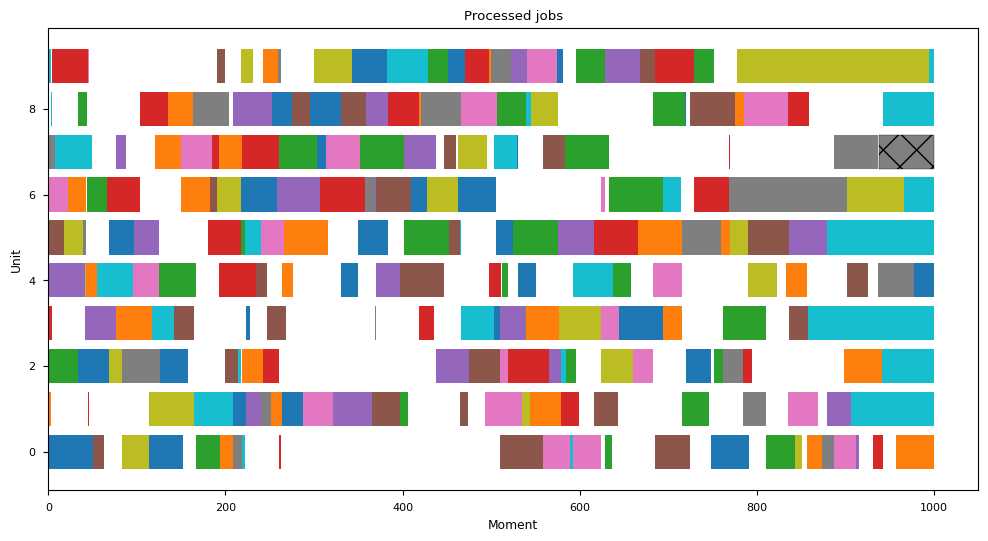

In [347]:
plot_gantt(
    production_logs,
    info=dict(
        window=[0, 1000],
        blocks=[
            dict(
                events=['started_processing', 'finished_processing'],
                style=dict()
            ),
            dict(
                events=['machine_breakdown', 'machine_repair'],
                style=dict(
                    color='gray',
                    edgecolor='black',
                    hatch='\\/'
                )
            )
        ],
        title='Processed jobs',
        xlabel='Moment',
        ylabel='Unit'
    )
);